we are using Optuna for hyperparameter optimization. The best trial so far has achieved a loss value of 0.010411433193965022 with the following parameters:
sequence_length: 34
embedding_size: 23
lstm_units: 256
dropout_rate: 0.100
batch_size: 32
epochs: 50

In [1]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project/middle_model
/home/ladans/DNN/Project/middle_model/Dataset


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, BatchNormalization
from keras.layers import Flatten, RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error

2024-11-24 16:55:10.942248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732467310.968167  305428 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732467310.979275  305428 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 16:55:11.008008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Directory containing CSV files
data_dir = dir_base  # Define this as your base directory

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path)
    df['Stock_Symbol'] = stock_symbol
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])

# Normalize prices using MinMaxScaler across all stocks
scaler = MinMaxScaler(feature_range=(0, 1))
all_data['Normalized_Close'] = all_data.groupby('Stock_Symbol')['Close'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

all_data.head()

,Date,Open,Close,Stock_Symbol,Stock_Index,Normalized_Close
0,2012-09-04,95.108574,96.424286,AAPL,0,0.375340
1,2012-09-05,96.510002,95.747147,AAPL,0,0.369085
2,2012-09-06,96.167145,96.610001,AAPL,0,0.377055
3,2012-09-07,96.864288,97.205711,AAPL,0,0.382558
4,2012-09-10,97.207146,94.677139,AAPL,0,0.359201


In [5]:
# Parameters
sequence_length = 34  # Adjusted based on optimization
#test_ratio = 0.2

# Initialize lists for inputs and outputs
X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    normalized_prices = stock_data['Normalized_Close'].values

    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)
print('done')

done


In [6]:
# Train-test split
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
train_size = int(len(X) * train_ratio)
validation_size = int(len(X) * validation_ratio)

# Perform the splits
X_train = X[:train_size]
y_train = y[:train_size]
stock_indices_train = stock_indices[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]
stock_indices_val = stock_indices[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]
stock_indices_test = stock_indices[train_size + validation_size:]

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print sizes for verification
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 3427
Validation samples: 734
Test samples: 735


In [7]:
#Model:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size =23 # Increased embedding size based on Optuna

# Define inputs
price_input = Input(shape=(sequence_length,1), name="price_input")
stock_input = Input(shape=(1,), name="stock_input")


# Embedding layer for stock index
stock_embedding = Embedding(input_dim=num_stocks, output_dim=embedding_size)(stock_input)
stock_embedding = Flatten()(stock_embedding)  # Flatten to 2D (batch_size, embedding_size)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)  # Replicate to match LSTM input shape

# Concatenate price input with stock embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])


# LSTM layer
# LSTM layers with dropout
lstm_out = LSTM(units=256, return_sequences=True)(merged_input)
lstm_out = Dropout(0.1)(lstm_out)
lstm_out = LSTM(units=128)(lstm_out)

# Output layer
output = Dense(units=1)(lstm_out)


# Define and compile the model
model = Model(inputs=[price_input, stock_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# Train the model with validation data
history = model.fit(
    [X_train, stock_indices_train], y_train,
    validation_data=([X_val, stock_indices_val], y_val),
    epochs=50,#based on optuna
    batch_size=32,#based on optuna
    verbose=1
)

Epoch 1/50


W0000 00:00:1732467313.336149  305428 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0126 - val_loss: 7.7518e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 6.6813e-04 - val_loss: 8.0635e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 7.0221e-04 - val_loss: 6.0432e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 7.8570e-04 - val_loss: 9.3710e-04
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 7.4288e-04 - val_loss: 5.3770e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 5.0068e-04 - val_loss: 4.5030e-04
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4.5532e-04 - val_loss: 4.4991e-04
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 4.5050e-04 - val_loss: 2.8903e-04
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4.3614e-04 - val_loss: 2.6781e-04
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 3.8378e-04 - val_loss: 3.0479e-04
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 3

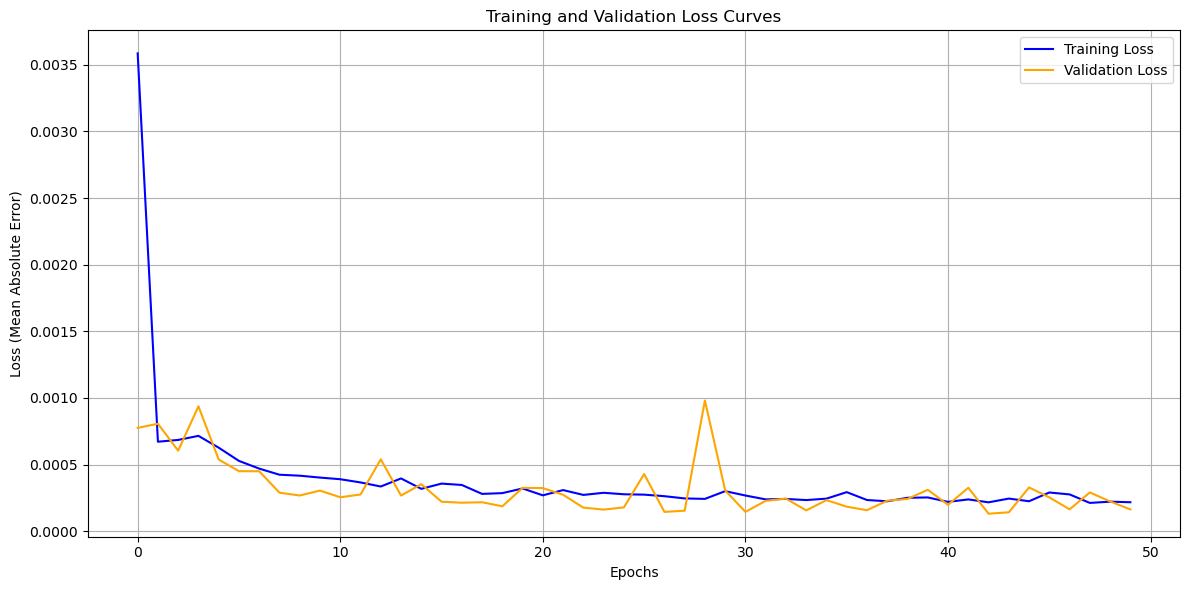

In [8]:
import matplotlib.pyplot as plt

# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_optimized')
plt.show()


In [9]:
#Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

# Denormalize predictions and actual values
def denormalize(values, stock_symbol):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_prices = all_data[all_data['Stock_Symbol'] == stock_symbol]['Close'].values
    scaler.fit(stock_prices.reshape(-1, 1))
    return scaler.inverse_transform(values.reshape(-1, 1)).flatten()

y_test_denormalized = np.concatenate([
    denormalize(y_test[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

predicted_prices_denormalized = np.concatenate([
    denormalize(predicted_prices[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

# Calculate metrics
mae = mean_absolute_error(y_test_denormalized, predicted_prices_denormalized)
mse = mean_squared_error(y_test_denormalized, predicted_prices_denormalized)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_denormalized - predicted_prices_denormalized) / y_test_denormalized)) * 100

print("MAE (Original Scale):", mae)
print("MSE (Original Scale):", mse)
print("RMSE (Original Scale):", rmse)
print("MAPE:", mape, "%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
MAE (Original Scale): 0.6194438673635472
MSE (Original Scale): 0.6904233533310049
RMSE (Original Scale): 0.8309171759754428
MAPE: 1.164834482663447 %


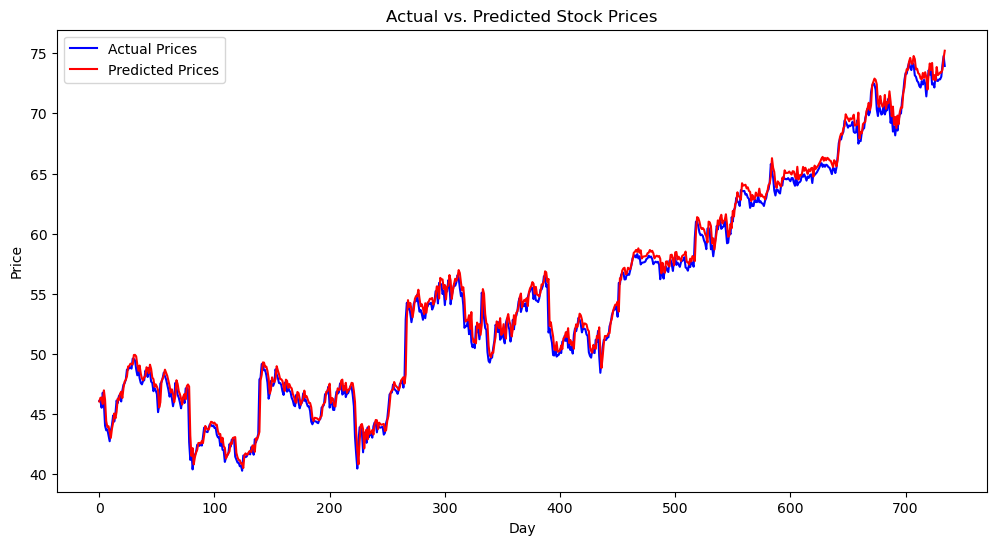

In [11]:
import matplotlib.pyplot as plt
# Plot reversed actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.savefig('actual_prediction_optimized')
plt.show()

# Evaluate per-stock metrics
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae_reversed = mean_absolute_error(
        y_test_denormalized[stock_mask], predicted_prices_denormalized[stock_mask]
    )

In [ ]:
# Predict the next price for a new sequence
array_34_values = X_test[-1]  

# Reshape new_sequence to match the model's expected input shape
new_sequence = array_34_values.reshape((1, sequence_length, 1))

# Find the encoded index for the desired stock (e.g., MSFT)
stock_index = encoder.transform(['MSFT'])

# Predict the normalized price
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization to get the predicted price in the original scale
predicted_price_original_scale = scaler.inverse_transform(predicted_normalized_price)[0][0]

print("Predicted next price for MSFT:", predicted_price_original_scale)


Predicted next price for MSFT : 75.40803
